In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as stats

import pandas as pd 
import seaborn as sns

%matplotlib inline
sns.set_style("white")

## Problem 2

Here, we model the net worth of company $i$, $V_i(T)$ with Merton Model:

$$V_i(T) = V_i(0)\times\Pi_{t=1}^T\left(1+\beta_i \sigma_F \epsilon_{F,t} + \sigma_i\epsilon_{i,t}\right).$$

The company value should stay above the liabilites of zero-coupon bonds: $V_i(T) > K_i$, and it also needs to remain above the net work covenant, $K_i^c$, described by:

$$K_i^c(T) = 0.9K_i + 0.1K_iT$$

### Part a)

Here, we compute how many firms violate the threshold $K_i^c$ and/or default, with $\beta=0.5, 1.0, 1.5$.

In [39]:
# The parameters
V_0 = 100
T = 252
K = 90 
lambda_F = 0.05/252
sigma_F = 0.15/np.sqrt(252)
sigma_i = 0.25/np.sqrt(252)

def network_cov(K_i, T):
    '''Return the net work covenant.'''
    return np.linspace(0.9*K, K, T)

def default_violation_rate(V_0, K, T, lambda_F, sigma_F, sigma_i, beta, runs=5000):
    '''Find the companies that default and/or violate the threshold.'''
    # Store whether company defaults or not (1: defaults, 0: not defaults)
    default_arr = np.zeros(runs, dtype=bool)
    # Same logic for threshold violation
    violation_arr = np.zeros(runs, dtype=bool)
    # For the companies that violate the threshold,
    # store at which time step this happens first
    violation_time_def = []
    violation_time_nodef = []
    for run in range(runs):
        eps_F = np.random.normal(lambda_F, sigma_F, T)
        eps_i = np.random.normal(0, sigma_i, T)
        # Does the company default?
        comp_value = V_0 * np.cumprod(1+beta*eps_F+eps_i)
        if comp_value[-1] < K:
            default_arr[run] = 1
        # Threshold violation?
        if (comp_value < network_cov(K,T)).any():
            violation_arr[run] = 1
            # Identify the time when the first threshold 
            # validation occurs, given that it happened
            first_viol_step = min( np.argwhere(comp_value < network_cov(K,T)).flatten() )
            # Distinguish the cases where the company also defaults
            if default_arr[run]:
                violation_time_def.append(first_viol_step)
            else:
                violation_time_nodef.append(first_viol_step)
    
    # Compute the average times for threshold violation
    # for both companies that default and companies that don't
    avg_violation_time = {}
    avg_violation_time['def'] = np.average(violation_time_def)
    avg_violation_time['nodef'] = np.average(violation_time_nodef)
       
    # Formulate the four cases 
    no_violation_no_def = ~(default_arr | violation_arr)
    no_violation_def = ~(violation_arr) & (default_arr)
    violation_no_def = (violation_arr) & ~(default_arr)
    violation_def = (violation_arr) & (default_arr)
    
    # Count the number of companies for each case
    counts = {}
    counts['no_violation_no_def'] = np.count_nonzero(no_violation_no_def)
    counts['no_violation_def'] = np.count_nonzero(no_violation_def)
    counts['violation_no_def'] = np.count_nonzero(violation_no_def)
    counts['violation_def'] = np.count_nonzero(violation_def)
    
    return counts, avg_violation_time

beta_arr = np.arange(1,4)*0.5
for beta in beta_arr:
    counts, avg_violation_time = default_violation_rate(V_0, K, T, lambda_F, sigma_F, sigma_i, beta=beta)
    print('*'*20)
    print(f'Beta: {beta}')
    print('*'*20)
    # Print out company counts
    print('COMPANY COUNTS:')
    for desc, count in counts.items():
        print(f'{desc}: {count}')
    # Print out the average times for threshold violation
    print('AVERAGE TIMES FOR THRESHOLD VIOLATION')
    for c, avg in avg_violation_time.items():
        print(f'{c}: {avg:.3f}')
    
  

********************
Beta: 0.5
********************
COMPANY COUNTS:
no_violation_no_def: 2241
no_violation_def: 0
violation_no_def: 995
violation_def: 1764
AVERAGE TIMES FOR THRESHOLD VIOLATION
def: 111.509
nodef: 116.374
********************
Beta: 1.0
********************
COMPANY COUNTS:
no_violation_no_def: 2165
no_violation_def: 0
violation_no_def: 1068
violation_def: 1767
AVERAGE TIMES FOR THRESHOLD VIOLATION
def: 109.141
nodef: 112.800
********************
Beta: 1.5
********************
COMPANY COUNTS:
no_violation_no_def: 2011
no_violation_def: 0
violation_no_def: 1202
violation_def: 1787
AVERAGE TIMES FOR THRESHOLD VIOLATION
def: 98.022
nodef: 100.903


## Problem 3


In [2]:
df = pd.read_csv('../data/YieldCurve.csv')
df = df.dropna()
df.head()

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,3/1/06,4.45,4.60,4.75,4.74,4.71,4.68,4.63,4.60,4.59,4.74,4.56
1,3/2/06,4.45,4.62,4.75,4.74,4.72,4.72,4.68,4.66,4.64,4.80,4.62
2,3/3/06,4.45,4.62,4.75,4.75,4.76,4.75,4.71,4.69,4.68,4.84,4.66
3,3/6/06,4.44,4.60,4.77,4.77,4.77,4.77,4.76,4.74,4.74,4.91,4.72
4,3/7/06,4.47,4.60,4.77,4.77,4.77,4.79,4.76,4.75,4.74,4.91,4.72


In [4]:
# Get first data point for December in each year
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].map(lambda x: x.strftime('%Y'))
df['month'] = df['Date'].map(lambda x: x.strftime('%m'))

dec_data = df.groupby('month').get_group('12').groupby('year').first()
# Drop the month column
dec_data = dec_data.drop(columns=['month'])
dec_data

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
year,,,,,,,,,,,,
2006,2006-12-01,5.21,5.03,5.05,4.87,4.52,4.43,4.39,4.39,4.43,4.64,4.54
2007,2007-12-03,3.55,3.06,3.28,3.15,2.90,2.93,3.28,3.53,3.89,4.38,4.34
2008,2008-12-01,0.09,0.07,0.44,0.81,0.90,1.16,1.71,2.13,2.72,3.51,3.22
2009,2009-12-01,0.09,0.06,0.15,0.26,0.67,1.14,2.03,2.74,3.28,4.14,4.26
2010,2010-12-01,0.17,0.16,0.20,0.28,0.53,0.84,1.64,2.33,2.97,3.95,4.24
2011,2011-12-01,0.02,0.01,0.05,0.12,0.27,0.41,0.97,1.55,2.11,2.82,3.12
2012,2012-12-03,0.13,0.10,0.14,0.18,0.25,0.34,0.63,1.05,1.63,2.37,2.80
2013,2013-12-02,0.02,0.05,0.10,0.13,0.30,0.59,1.43,2.16,2.81,3.58,3.86
2014,2014-12-01,0.01,0.03,0.08,0.13,0.49,0.90,1.52,1.93,2.22,2.66,2.95


/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


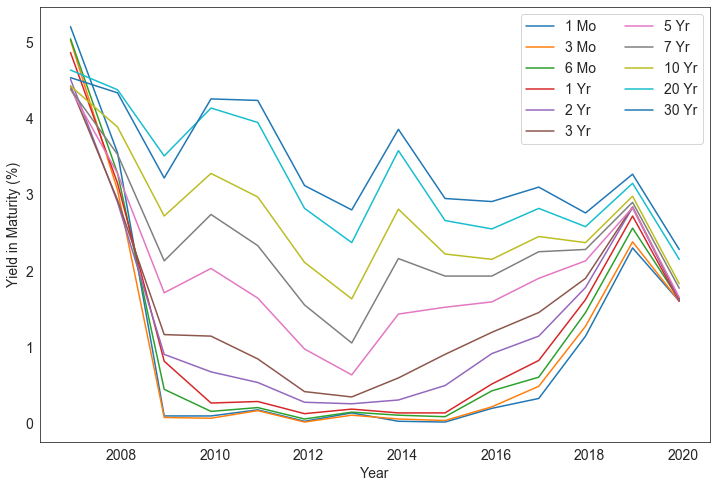

In [5]:
plt.rcParams.update({'font.size': 14})
labels = dec_data.columns[1:]
fig, ax = plt.subplots(1,1,figsize=(12,8))
for idx, label in enumerate(labels):
    ax.plot(dec_data.values[:,0], dec_data.values[:,idx+1], label=label)
ax.legend(ncol=2)
ax.set_xlabel('Year')
ax.set_ylabel('Yield in Maturity (%)')
fig.savefig('../output/yield_curve.pdf')

In [6]:
import sklearn.decomposition.pca as PCA
clean_df = dec_data.drop(columns='Date')
pca = PCA.PCA(n_components=3)
pca.fit(clean_df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

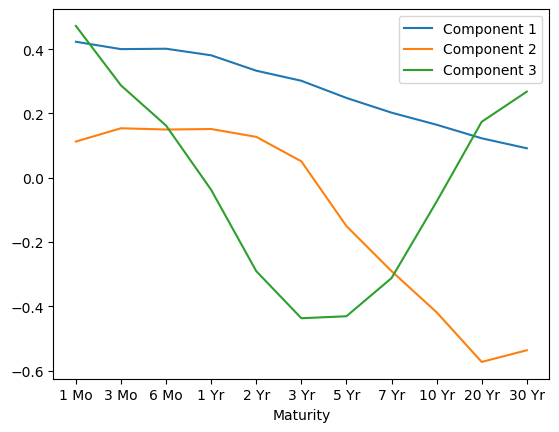

In [23]:
# Plot first three components
import matplotlib as mpl
# Get back to default font settings
mpl.rcParams.update(mpl.rcParamsDefault)

comp = pca.components_

fig, ax = plt.subplots(1,1)
for idx, c in enumerate(comp):
    ax.plot(labels, c, label=f'Component {idx+1}')
ax.legend()
ax.set_xlabel('Maturity')
fig.savefig('../output/pca.pdf')

In [8]:
pca.components_

array([[ 0.42302104,  0.40006546,  0.40130431,  0.38083473,  0.33295506,
         0.30157615,  0.24821043,  0.20236588,  0.16476576,  0.12258984,
         0.09152567],
       [ 0.11251255,  0.15381204,  0.14991067,  0.15146433,  0.12707424,
         0.05089252, -0.1505725 , -0.29073308, -0.41878713, -0.57324496,
        -0.53697297],
       [ 0.47226622,  0.28715204,  0.16214637, -0.0377864 , -0.29080163,
        -0.43728248, -0.43114238, -0.31238987, -0.07438512,  0.17406743,
         0.26777548]])

In [21]:
pca.explained_variance_ratio_

array([0.9038499 , 0.08180586, 0.01156842])